In [1]:
# 02_main.ipynb
from grav_lens import get_datasets

from utils.model import create_model
from utils.loadsave import load_model_with_hyperparameters, load_hyperparameters, save_hyperparameters
from utils.optimize import dimensions, default_parameters


from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
import time
import pickle

from tensorflow.keras import backend as K

from functools import partial

In [2]:
import os 

# mi carpeta data se encuentra en el root
home_data = os.path.join("..", "..")
# Ejemplo de uso
# INDEX 0 es una carpeta de datasets mucho mas chica
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=500, home=home_data)

for X, Y in train_dataset.take(1):  # Mostrar un batch de entrenamiento
    print("Train X:", X.shape)
    print("Train Y:", Y.shape)

for X, Y in val_dataset.take(1):  # Mostrar un batch de validación
    print("Val X:", X.shape)
    print("Val Y:", Y.shape)

for X, Y in test_dataset.take(1):  # Mostrar un batch de prueba
    print("Test X:", X.shape)
    print("Test Y:", Y.shape)


Using data folder: ..\..\data\1
Train X: (32, 128, 128, 3)
Train Y: (32, 128, 128, 1)
Val X: (32, 128, 128, 3)
Val Y: (32, 128, 128, 1)
Test X: (32, 128, 128, 3)
Test Y: (32, 128, 128, 1)


# Definiendo Funcion Optimizacion
Se ha intentado modularizar pero resulta en problems de pickling

In [3]:
best_loss = float('inf')
counter = 1
@use_named_args(dimensions=dimensions)
def F_objective(learning_rate, 
     in_activation, h_activation, out_activation, 
     h_kernel_size, hidden_filters, 
     out_kernel_size, weight_kl, 
     beta_1, beta_2, epsilon, amsgrad, 
     decay_steps, decay_rate, epochs):
    """
    Función objetivo para la optimización de hiperparámetros.
    """
    global best_loss, counter
    model = create_model(learning_rate, 
                        in_activation, h_activation, 
                        out_activation, h_kernel_size, 
                        hidden_filters, out_kernel_size, 
                        weight_kl, beta_1, beta_2, 
                        epsilon, amsgrad, 
                        decay_steps, decay_rate)

    model.fit(train_dataset, epochs=epochs, verbose=True)

    loss = model.evaluate(val_dataset, verbose=False)

    print(f"\nLoss: {loss:.2%}\n")

    if loss < best_loss:
        model.save_weights(f'best_model_{counter}.weights.h5')
        save_hyperparameters(
            learning_rate, in_activation, 
            h_activation, out_activation, 
            h_kernel_size, hidden_filters, 
            out_kernel_size, weight_kl, 
            beta_1, beta_2, epsilon, 
            amsgrad, decay_steps, 
            decay_rate, counter
        )
        print(f"Model weights and hyperparameters saved with ID: {counter}")
        counter += 1
        best_loss = loss

    K.clear_session()
    return loss

In [4]:
def run_hyp_optimize(dimensions, default_parameters, n_calls=17):
    best_loss = float('inf')
    counter = 1
    checkpoint_saver = CheckpointSaver("checkpoint.pkl", compress=9)

    start_time = time.time()
    res = gp_minimize(
        func=F_objective,  # Pasar la función parcial
        dimensions=dimensions,
        acq_func='EI', 
        n_calls=n_calls,
        x0=default_parameters,
        callback=[checkpoint_saver]
    )
    end_time = time.time()

    execution_time_minutes = (end_time - start_time) / 60
    print(f"Execution time: {execution_time_minutes:.2f} minutes")
    return res


In [5]:
# test optimize, corre una unica vez la funcion F a optimizar
# hyp_optimizer.run_test_optimize(train_dataset, val_dataset, verbose_train=True, verbose_val=True)

# La Gran Minimizacion
La siguiente funcion correra aproximadamente `n_calls` * el tiempo que corrio el paso anterior, debes tener en cuenta si se entrenan epocas y otras que aumenten el tiempo de manera no lineal dependiendo de la accion del hiperparametro

In [6]:
res = run_hyp_optimize(dimensions, default_parameters, n_calls=17)

# Guardar el objeto res, para hacer estadistica despues
with open('optimization_results.pkl', 'wb') as f:
    pickle.dump(res, f)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 98s 9s/step - loss: 0.4914
Epoch 2/10


c:\Users\danij\anaconda3\envs\tf\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 95s 9s/step - loss: 0.4638
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 94s 9s/step - loss: 0.4258
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - loss: 0.3820
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 98s 9s/step - loss: 0.3397
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - loss: 0.3005
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - loss: 0.2692
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - loss: 0.2450
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - loss: 0.2269
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - loss: 0.2149

Loss: 31.28%

Model weights and hyperparameters saved with ID: 1

Epoch 1/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.3964
Epoch 2/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0659
Epoch 3/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0598
Epoch 4/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0575
Epoch 5/12
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0596
Epoch 6/12
11/11 ━━━━━━━━━━━━━━━━

c:\Users\danij\anaconda3\envs\tf\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.4885
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.4883
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4874
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4872
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4839
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4833
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4807
Epoch 9/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4788
Epoch 10/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4758
Epoch 11/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4732
Epoch 12/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4669
Epoch 13/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4638
Epoch 14/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4591
Epoch 15/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4538
Epoch 16/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4487
Epoch 17/25
11/11 ━━━━━━━━━━━

c:\Users\danij\anaconda3\envs\tf\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.3046
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.2739
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.2411
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.2344
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.2250
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.1999
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.1766
Epoch 9/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.1646
Epoch 10/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.1458
Epoch 11/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.1410
Epoch 12/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.1360
Epoch 13/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.1250
Epoch 14/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.1128
Epoch 15/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 0.1021
Epoch 16/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 0.0911
Epoch 17/25
11/11 ━━━━━━━━━━━

c:\Users\danij\anaconda3\envs\tf\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 0.4926
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - loss: 0.4873
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 0.4810
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 0.4754
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 0.4676
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 0.4578
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 0.4464
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - loss: 0.4354
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 0.4240

Loss: 24.85%

Epoch 1/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.4651
Epoch 2/19


c:\Users\danij\anaconda3\envs\tf\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.1179
Epoch 3/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0435
Epoch 4/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0421
Epoch 5/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0419
Epoch 6/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0411
Epoch 7/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0418
Epoch 8/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0423
Epoch 9/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0422
Epoch 10/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0422
Epoch 11/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0422
Epoch 12/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0420
Epoch 13/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0422
Epoch 14/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0426
Epoch 15/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0420
Epoch 16/19
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0419
Epoch 17/19
11/11 ━━━━━━━━━━━

c:\Users\danij\anaconda3\envs\tf\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - loss: 0.3963
Epoch 3/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - loss: 0.3614
Epoch 4/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - loss: 0.3394
Epoch 5/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - loss: 0.3257
Epoch 6/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - loss: 0.3145
Epoch 7/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - loss: 0.3047
Epoch 8/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - loss: 0.2956
Epoch 9/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - loss: 0.2875
Epoch 10/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - loss: 0.2813
Epoch 11/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - loss: 0.2752
Epoch 12/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - loss: 0.2692
Epoch 13/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - loss: 0.2637
Epoch 14/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - loss: 0.2583
Epoch 15/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - loss: 0.2528
Epoch 16/17
11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - loss: 0.2477
Epoch 17/17
11/11 ━━━━━━━━━━━

c:\Users\danij\anaconda3\envs\tf\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 798s 73s/step - loss: 0.5194
Epoch 3/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 795s 73s/step - loss: 0.4589
Epoch 4/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 797s 74s/step - loss: 0.4131
Epoch 5/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 796s 69s/step - loss: 0.3711
Epoch 6/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 856s 76s/step - loss: 0.3405
Epoch 7/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 833s 77s/step - loss: 0.3147
Epoch 8/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 839s 77s/step - loss: 0.2907
Epoch 9/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 801s 73s/step - loss: 0.2688
Epoch 10/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 776s 69s/step - loss: 0.2508
Epoch 11/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 756s 68s/step - loss: 0.2322
Epoch 12/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 829s 76s/step - loss: 0.2163
Epoch 13/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 718s 65s/step - loss: 0.2047
Epoch 14/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 760s 66s/step - loss: 0.1893
Epoch 15/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 753s 68s/step - loss: 0.1791
Epoch 16/22
11/11 ━━━━━━━━━━━━━━━━━━━━ 701s 63s/step - loss: 0.1676

# Graficos

In [7]:
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None),
       Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None),
       Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None),
       Integer(low=2, high=7, prior='uniform', transform='normalize'),
       Integer(low=16, high=128, prior='uniform', transform='normalize'),
       Integer(low=2, high=7, prior='uniform', transform='normalize'),
       Real(low=0.01, high=2.0, prior='log-uniform', transform='normalize'),
       Real(low=0.0, high=0.99, prior='uniform', transform='normalize'),
       Real(low=0.0, high=0.999, prior='uniform', transform='normalize'),
       Real(low=1e-08, high=0.0001, prior='log-uniform', transform='normalize'),
       Categorical(categories=(True, False), prior=None),
       Integer(low=1000, high=50000, prior='uniform', transform='normalize'),
       Real(low=0.8, high=0.99, prior='uniform',

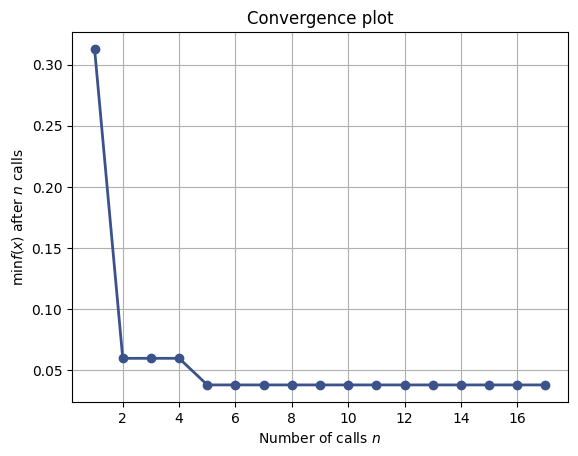

In [8]:
plot_convergence(res)
print(res.space)
print(res.x)
print("Accuracy: ", res.fun)

In [9]:
from skopt.plots import plot_histogram, plot_objective_2D

plot_histogram(result=res,  dimension_identifier='activation')
plt.show()

TypeError: list indices must be integers or slices, not NoneType

In [ ]:
plot_objective(result=res, dimensions=dimension_names)

In [ ]:
plot_evaluations(result=res, dimensions=dimension_names)